In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

In [44]:
from hyperopt import hp, tpe, Trials, fmin, space_eval

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# 警告メッセージを非表示にする
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

今回は、CreditCardの分類問題をランダムフォレスト、サポートベクターマシン、XGBoostを用いてとく。  
また、ランダムフォレストを用いた特徴量選択を行う。  
特徴量選択をしたものと、しないものとの比較をする。  
また、ランダムフォレスト、サポートベクターマシン、XGBoostそれぞれにおいて交差検証をおこなってハイパーパラメータを設定する。  

まずはEDA、データがどんなものなのか、どんな分布をしているのかなど調べたり、可視化してみる

In [3]:
credit = pd.read_csv('./data/creditcard.csv')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [5]:
credit.shape

(284807, 31)

In [6]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

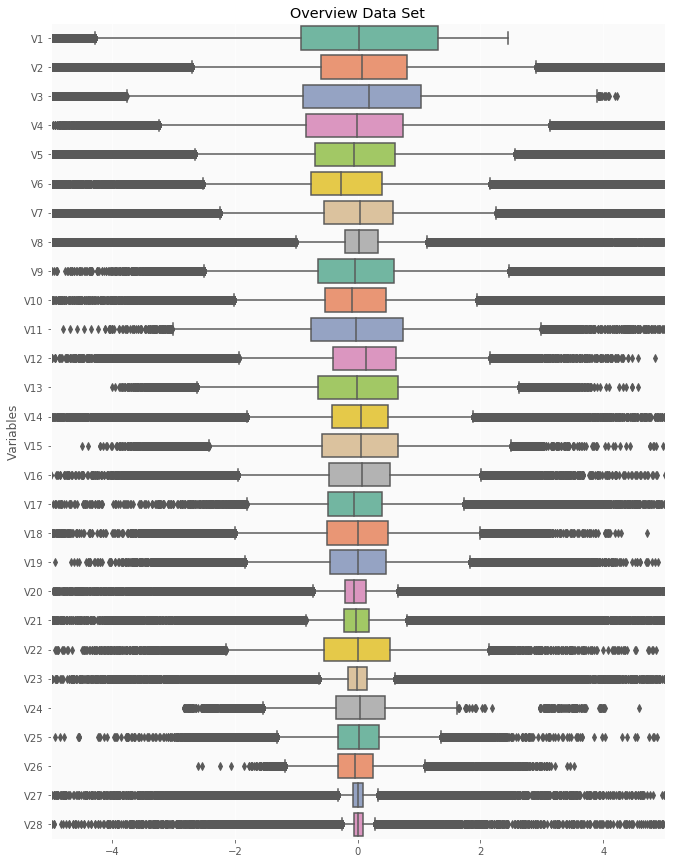

In [7]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(11,15))
ax.set_facecolor('#fafafa')
ax.set(xlim=(-5,5))
plt.ylabel('Variables')
plt.title('Overview Data Set')
ax = sns.boxplot(data=credit.drop(columns=['Amount', 'Class', 'Time']), orient='h', palette='Set2')

これによると、特徴量ごとに分散がことなったり、しているが、平均はどの変数も0周辺であることがわかる。

In [8]:
fraud = credit[(credit['Class'] != 0)]
normal = credit[(credit['Class'] == 0)]

trace = go.Pie(labels=['Normal', 'Fraud'], values=credit['Class'].value_counts(), textfont=dict(size=15), opacity=0.8, marker=dict(colors=['lightskyblue', 'gold'], line=dict(color='#000000', width=1.0)))
layout = dict(title='Distribution of target variable')

fig = dict(data=[trace], layout=layout)
py.iplot(fig)

これによると、ほとんどがNormal, 0 のクラスで、残りの 0.173%が1のクラスであることがわかる  
Plotlyは、マウスベースの扱いができるグラフを作ることができる。  
上の図の例だとわかりづらいが、例えば上ではπチャートの領域部分にマウスを表すと、その領域の名前や個数、パーセントが表示される。  
他にも折れ線グラフでは、たとえば特定の期間を拡大してみてみたり、といったこともできるようになる。  

In [9]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


統計量をみたところ、基本的な特徴量(v1 ~ v28)は最小値、最大値、また平均値からどれも同じくらいなのでよいが、Amountだけ外れ値があることがわかる。  
そこで、今回は標準化することにする  

In [10]:
# 標準化する
from sklearn.preprocessing import StandardScaler
credit['nAmount'] = StandardScaler().fit_transform(credit['Amount'].values.reshape(-1,1))

In [11]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,nAmount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403


In [12]:
# 元のAmount列と予測に使わないTime列を削除する
credit = credit.drop(['Time', 'Amount'], axis=1)

In [13]:
credit.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,nAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [14]:
# null値がないか確認する
credit.isnull().sum()

V1         0
V2         0
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
Class      0
nAmount    0
dtype: int64

In [15]:
random_state=42

In [16]:
train_set, test_set = train_test_split(credit, test_size=0.2, random_state=random_state, stratify=credit['Class'])

In [17]:
# 欠損値も特にないようなので、予測に移る
y = np.array(credit.Class.tolist())
credit = credit.drop('Class', 1)
credit.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,nAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [18]:
X = np.array(credit.as_matrix())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [19]:
X.shape

(284807, 29)

In [20]:
y.shape

(284807,)

In [21]:
random_state=42

In [22]:
# 今回、クラス分けするにあたって、クラスが0の量が圧倒的に多く、1が圧倒的に少ないため、訓練データ、テストデータを分ける際に隔たりがなるべくなくなるよう、stratifi=yとした
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

X_train2 = train_set.drop('Class', axis=1)
y_train2 = train_set['Class'].copy()

X_test2 = test_set.drop('Class', axis=1)
y_test2 = test_set['Class'].copy()

ここでいったん、特徴量毎のターゲットの分布を可視化する  
分類問題では特徴量毎にターゲットの分布を確認することは大事である。  
ターゲットの分布がきれいに分離しているほど、特徴量として有益ととらえることができるためである。  

In [23]:
features = credit.columns
features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'nAmount'],
      dtype='object')

In [24]:
train_set[features]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,nAmount
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,-0.157403,...,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,-0.323963
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,0.284864,...,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,-0.341275
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,-2.009561,...,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,0.346835
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,...,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,-0.328841
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,...,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,-0.008994
130664,1.320449,-1.560991,-0.154324,-1.806184,-0.831334,0.877820,-1.212515,0.246020,-1.747897,1.518364,...,-0.123905,-0.346511,-0.941239,-0.104322,-1.790279,0.184198,-0.299018,0.025862,0.016056,0.147691
158877,1.902180,0.158704,-0.210092,3.459251,0.346012,1.465813,-0.749323,0.432622,-0.390130,1.554882,...,-0.250456,0.208545,0.646480,0.075336,-0.176780,-0.095253,0.090097,0.004346,-0.045702,-0.347192
242784,2.091991,-1.009477,-0.885660,-0.424255,-0.575602,0.486532,-1.033124,0.201550,0.263308,0.794406,...,-0.639071,-0.158022,0.244872,0.083967,0.116089,0.032727,-0.123307,0.042437,-0.051537,-0.305292
270403,-3.309691,-5.662946,0.466119,-0.430087,3.664003,-3.036146,-2.841650,0.520501,1.485832,-0.499631,...,1.535663,0.819604,0.742448,1.745293,-0.490856,-2.153907,0.173475,0.119893,0.467544,0.480771
235709,1.973973,-0.404605,-0.222072,0.534479,-0.830112,-0.626462,-0.595997,-0.066845,1.465829,-0.166011,...,-0.220785,0.194876,0.822169,0.120061,0.072218,-0.097635,-0.215837,0.041900,-0.036105,-0.313289


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



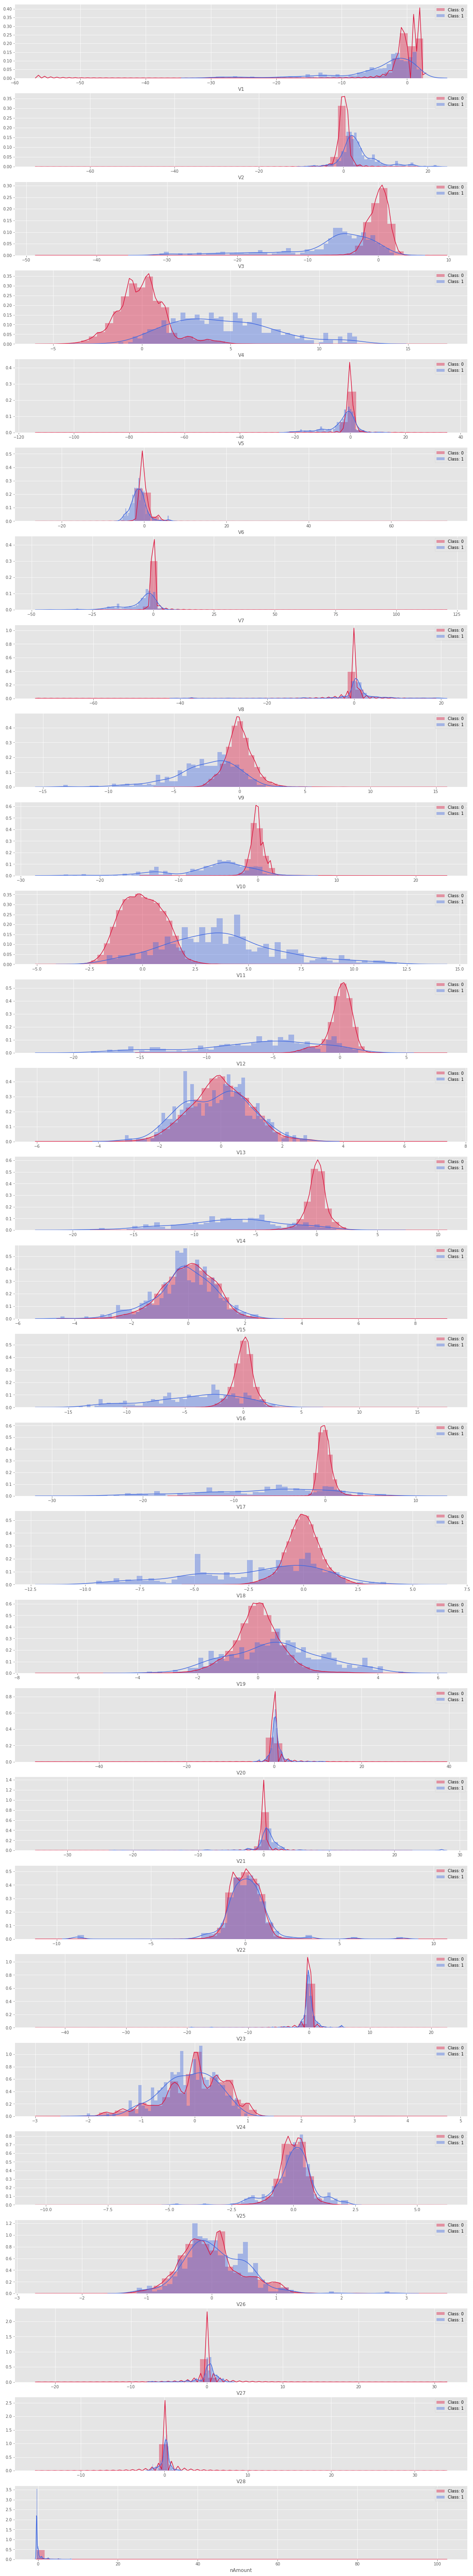

In [25]:
legend=['Class: 0', 'Class: 1']

plt.figure(figsize=(20, 32*4))
gs = gridspec.GridSpec(32,1)
for i, col in enumerate(train_set[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(train_set[col][train_set.Class==0], bins=50, color='crimson')
    sns.distplot(train_set[col][train_set.Class==1], bins=50, color='royalblue')
    plt.legend(legend)

結果から、 V2, V3, V4, V7, V9, V10, V11, V12, V14, V16, V17, V18, nAmountらへんは比較的データが重なっている部分が少ないため、良い特徴量なのではないか、と疑うことができる  
せっかくなので、特徴量選択をすることにする

In [26]:
%%time
from sklearn.ensemble import RandomForestClassifier
# 特徴量選択
RF = RandomForestClassifier(n_estimators=250, random_state=42)
RF.fit(X_train, y_train)

Wall time: 13min 22s


In [27]:
# 重要度が高い順にソートして表示
importances = RF.feature_importances_

print('重要度が高い特徴量順: ')
print(sorted(zip(map(lambda x: round(x, 2), RF.feature_importances_), features), reverse=True))

重要度が高い特徴量順: 
[(0.17, 'V17'), (0.13, 'V12'), (0.12, 'V14'), (0.08, 'V10'), (0.07, 'V11'), (0.06, 'V16'), (0.03, 'V9'), (0.03, 'V7'), (0.03, 'V4'), (0.03, 'V18'), (0.02, 'V3'), (0.02, 'V26'), (0.02, 'V21'), (0.02, 'V1'), (0.01, 'nAmount'), (0.01, 'V8'), (0.01, 'V6'), (0.01, 'V5'), (0.01, 'V28'), (0.01, 'V27'), (0.01, 'V25'), (0.01, 'V24'), (0.01, 'V23'), (0.01, 'V22'), (0.01, 'V20'), (0.01, 'V2'), (0.01, 'V19'), (0.01, 'V15'), (0.01, 'V13')]


v2は予測とはずれてしまったが、あとはおおむね予測下通りとなった。  
よってここでは、とりあえず V17, V12, V14, V10, V11, V16, V9, V7, V4, V18, V3の11個の特徴量を使うことにした。 

In [26]:
X_train2 = X_train2[['V17', 'V12', 'V14', 'V10', 'V11', 'V16', 'V9', 'V7', 'V4', 'V18', 'V3']]
X_test2 = X_test2[['V17', 'V12', 'V14', 'V10', 'V11', 'V16', 'V9', 'V7', 'V4', 'V18', 'V3']]

## 性能評価
性能評価では、今回は分類問題のため以下の指標を用いて評価している  
正解率(accuracy_score)  
適合率(precision_score)  
再現率(recall_score)  
f1_Score  

In [55]:
def full_model_eva(model):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    # 正解率
    print('正解率: {:.7f}'.format(accuracy_score(y_test, predict)))
    # 適合率
    print('適合率: {:.7f}'.format(precision_score(y_test, predict)))
    # 再現率
    print('再現率: {:.7f}'.format(recall_score(y_test, predict)))
    # f1_score
    print('f1_score: {:.7f}'.format(f1_score(y_test, predict)))

In [56]:
def partical_model_eva(model):
    model.fit(X_train2, y_train2)
    predict = model.predict(X_test2)
    # 正解率
    print('正解率: {:.7f}'.format(accuracy_score(y_test2, predict)))
    # 適合率
    print('適合率: {:.7f}'.format(precision_score(y_test2, predict)))
    # 再現率
    print('再現率: {:.7f}'.format(recall_score(y_test2, predict)))
    # f1_score
    print('f1_score: {:.7f}'.format(f1_score(y_test2, predict)))

### サポートベクターマシン

In [27]:
# まずはハイパーパラメータを調整しないで結果がどうなるか見てみる
SV = SVC(random_state=42)

#### 全特徴量使用モデル

In [59]:
full_model_eva(SV)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



正解率: 0.9993680
適合率: 0.9428571
再現率: 0.6734694
f1_score: 0.7857143


##### 選択特徴量使用モデル

In [60]:
partical_model_eva(SV)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



正解率: 0.9994558
適合率: 0.9589041
再現率: 0.7142857
f1_score: 0.8187135


### ハイパーパラメータの調整

In [27]:
hyperopt_parameters = {
    'C':hp.loguniform("C", np.log(1), np.log(100)),
    'kernel':hp.choice('kernel',['rbf','poly']),
    'gamma': hp.loguniform("gamma", np.log(0.001), np.log(0.1))
}

In [28]:
def objective(params):
    print(params)
    global count
    count += 1
    # モデルのインスタンス化
    classifier = SVC(**params)
    # trainデータを使ってモデルの学習
    classifier.fit(X_train2, y_train2)
    # validationデータを使用して、ラベルの予測
    predicts = classifier.predict(X_test2)
    # 予測ラベルと正解ラベルを使用して accuracy_score を計算
    ac_score = accuracy_score(y_test2, predicts)
    print('{}回目の計測結果の正解率: {}'.format(count, ac_score))
    # 今回は accuracy_score を最大化したいので、 1 をかけて最小化に合わせる
    return -1 * ac_score

In [33]:
# ログのためのカウント
count = 0

# iterationする回数
max_evals = 200
# 試行の回数を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する関数を定義した関数
    objective,
    # 探索するパラメータのdict, もしくはlist
    hyperopt_parameters,
    # どのロジックを利用するか、基本的には tpe.suggest で大丈夫らしい
    algo = tpe.suggest,
    max_evals = max_evals,
    trials = trials,
    # 試行の過程を出力
    verbose = 1
)

print("best estimate parameters")
print(best)

clf = SVC(**best)
print(clf)

{'C': 27.247695940562437, 'gamma': 0.001472519424237431, 'kernel': 'rbf'}                                                                                  
1回目の計測結果の正解率: 0.999403110845827                                                                                                                            
{'C': 18.271908347075076, 'gamma': 0.09182543155627425, 'kernel': 'rbf'}                                                                                   
2回目の計測結果の正解率: 0.999403110845827                                                                                                                            
{'C': 17.10105206429924, 'gamma': 0.002629737005989002, 'kernel': 'poly'}                                                                                  
3回目の計測結果の正解率: 0.9992099996488887                                                                                                                           
{'C': 16.0533429266779, 'gamma': 0.003336400647382535, 'kernel':

{'C': 65.89859083898135, 'gamma': 0.005383307515359376, 'kernel': 'rbf'}                                                                                   
53回目の計測結果の正解率: 0.9995962220427653                                                                                                                          
{'C': 77.42946708138037, 'gamma': 0.002455563487717206, 'kernel': 'rbf'}                                                                                   
54回目の計測結果の正解率: 0.9994382219725431                                                                                                                          
{'C': 2.40894817969229, 'gamma': 0.016010466615437736, 'kernel': 'poly'}                                                                                   
55回目の計測結果の正解率: 0.9993679997191109                                                                                                                          
{'C': 59.546048329521355, 'gamma': 0.001904172233987029, 'kernel

{'C': 2.694981445809582, 'gamma': 0.0909280663388939, 'kernel': 'rbf'}                                                                                     
105回目の計測結果の正解率: 0.9994557775359011                                                                                                                         
{'C': 29.846632285275014, 'gamma': 0.003840083214636077, 'kernel': 'rbf'}                                                                                  
106回目の計測結果の正解率: 0.9994557775359011                                                                                                                         
{'C': 26.063954004603318, 'gamma': 0.0047411271292533055, 'kernel': 'rbf'}                                                                                 
107回目の計測結果の正解率: 0.9994733330992591                                                                                                                         
{'C': 7.666350044592698, 'gamma': 0.015244328635342008, 'kernel'

{'C': 6.673739953395587, 'gamma': 0.02636393431276191, 'kernel': 'rbf'}                                                                                    
157回目の計測結果の正解率: 0.9995786664794073                                                                                                                         
{'C': 9.434276512002223, 'gamma': 0.04337662308227662, 'kernel': 'rbf'}                                                                                    
158回目の計測結果の正解率: 0.9995786664794073                                                                                                                         
{'C': 18.73842964786575, 'gamma': 0.007875978640560834, 'kernel': 'rbf'}                                                                                   
159回目の計測結果の正解率: 0.9994908886626171                                                                                                                         
{'C': 5.220050262388529, 'gamma': 0.03309683945110471, 'kernel':

NameError: name 'svm' is not defined

In [34]:
print(best)

{'C': 5.89208911231663, 'gamma': 0.03609185918208991, 'kernel': 0}


In [ ]:
print('best parameter: ', space_eval(hyperopt_parameters, best))

In [ ]:
clf = SVC(C=5.89208911231663, gamma=0.03609185918208991, kernel='rbf', random_state=42)

In [ ]:
full_model_eva(clf)

##### 選択特徴量使用モデル

In [ ]:
partical_model_eva(clf)

### ランダムフォレスト

#### ハイパーパラメータ調整前

In [45]:
# ランダムフォレスト
RF = RandomForestClassifier(random_state=42)

#### 全特徴量を使ったモデル

In [46]:
%%time
RF.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Wall time: 34.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

##### 全特徴量使用モデル

In [57]:
full_model_eva(RF)

正解率: 0.9995260
適合率: 0.9493671
再現率: 0.7653061
f1_score: 0.8474576


##### 選択特徴量使用モデル

In [58]:
partical_model_eva(RF)

正解率: 0.9995787
適合率: 0.9512195
再現率: 0.7959184
f1_score: 0.8666667


### ハイパーパラメータ調整

In [56]:
hyperopt_parameters = {
    'n_estimators': hp.choice('n_estimators', np.arange(5, 125, 25, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 17, 5, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(2, 17, 5, dtype=int)),
    'max_depth': hp.quniform('max_depth', 10, 115, 15),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

In [54]:
def objective(params):
    # モデルのインスタンス化
    classifier = RandomForestClassifier(**params)
    # trainデータを使ってモデルの学習
    classifier.fit(X_train2, y_train2)
    # validationデータを使用して、ラベルの予測
    predicts = classifier.predict(X_test2)
    # 予測ラベルと正解ラベルを使用して accuracy_score を計算
    ac_score = accuracy_score(y_test2, predicts)
    # 今回は accuracy_score を最大化したいので、 1 をかけて最小化に合わせる
    return -1 * ac_score

In [57]:
# iterationする回数
max_evals = 100
# 試行の回数を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する関数を定義した関数
    objective,
    # 探索するパラメータのdict, もしくはlist
    hyperopt_parameters,
    # どのロジックを利用するか、基本的には tpe.suggest で大丈夫らしい
    algo = tpe.suggest,
    max_evals = max_evals,
    trials = trials,
    # 試行の過程を出力
    verbose = 1
)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [2:38:12<00:00, 36.89s/it, best loss: -0.9996664442961974]


In [63]:
print('best parameter: ', space_eval(hyperopt_parameters, best))

best parameter:  {'criterion': 'entropy', 'max_depth': 75.0, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 105}


In [82]:
RF = RandomForestClassifier(n_estimators=105, min_samples_split=12, min_samples_leaf=2, max_depth=75, criterion='entropy', random_state=42)

#### 全特徴量使用モデル

In [ ]:
full_model_eva(RF)

##### 選択特徴量使用モデル

In [ ]:
partical_model_eva(RF)

### XGBoost

In [61]:
XGB = XGBClassifier(random_state=42)

##### 全特徴量使用モデル

In [62]:
full_model_eva(XGB)

正解率: 0.9994909
適合率: 0.8876404
再現率: 0.8061224
f1_score: 0.8449198


#####  選択特徴量使用モデル

In [63]:
partical_model_eva(XGB)

正解率: 0.9994733
適合率: 0.8695652
再現率: 0.8163265
f1_score: 0.8421053


### ハイパーパラメータ調整

In [82]:
hyperopt_parameters = {
    'objective': 'binary:logistic',
    
    #Control complexity of model
    'eta' : hp.quniform('eta', 0.2, 0.6, 0.2),
    'max_depth' : hp.choice('max_depth', np.arange(2, 127, 25, dtype=int)),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 4),
    'gamma' : hp.quniform('gamma', 0, 1, 0.3),
        
    #Improve noise robustness 
    'subsample' : hp.quniform('subsample', 0.5, 1, 0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.1),
        
    'silent' : 1
}

In [85]:
def objective(params):
    # モデルのインスタンス化
    classifier = XGBClassifier(**params)
    # trainデータを使ってモデルの学習
    classifier.fit(X_train2, y_train2)
    # validationデータを使用して、ラベルの予測
    predicts = classifier.predict(X_test2)
    # 予測ラベルと正解ラベルを使用して accuracy_score を計算
    acc_score = accuracy_score(y_test2, predicts)
    # 今回は accuracy_score を最大化したいので、 1 をかけて最小化に合わせる
    return -1 * acc_score

In [86]:
# iterationする回数
max_evals = 100
# 試行の回数を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する関数を定義した関数
    objective,
    # 探索するパラメータのdict, もしくはlist
    hyperopt_parameters,
    # どのロジックを利用するか、基本的には tpe.suggest で大丈夫らしい
    algo = tpe.suggest,
    max_evals = max_evals,
    trials = trials,
    # 試行の過程を出力
    verbose = 1
)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [2:34:40<00:00, 90.72s/it, best loss: -0.9996839998595555]


In [87]:
print('best parameter: ', space_eval(hyperopt_parameters, best))

best parameter:  {'colsample_bytree': 0.9, 'eta': 0.2, 'gamma': 0.6, 'max_depth': 102, 'min_child_weight': 0.0, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.5}


In [88]:
XGB = XGBClassifier(colsample_bytree=0.9, learning_rate=0.2, gamma=0.6, max_depth=102, min_child_weight=0.0, objective='binary:logistic', subsample=0.5, random_state=42)

In [89]:
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.6, learning_rate=0.2,
       max_delta_step=0, max_depth=102, min_child_weight=0.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

#### 全特徴量使用モデル

In [90]:
full_model_eva(XGB)

正解率: 0.9995611
適合率: 0.9195402
再現率: 0.8163265
f1_score: 0.8648649


#####  選択特徴量使用モデル

In [91]:
partical_model_eva(XGB)

正解率: 0.9996313
適合率: 0.9425287
再現率: 0.8367347
f1_score: 0.8864865
